### 导入包

In [1]:
import numpy as np
import pandas as pd
import keras
import os
import time
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.models import load_model

Using TensorFlow backend.


## 绘制统计图类

In [2]:
# 绘制类
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch': [], 'epoch': []}
        self.accuracy = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        self.val_acc = {'batch': [], 'epoch': []}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        #创建一个图
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')#plt.plot(x,y)，这个将数据画成曲线
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)#设置网格形式
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')#给x，y轴加注释
        plt.legend(loc="upper right")#设置图例显示位置
        plt.show()

### 加载数据

In [3]:
# 初始化训练测试集
train = sio.loadmat("datanew.mat")['data']
label = sio.loadmat("labelnew.mat")['label']
# print(train.shape)
# print(label.shape)

# 标准化训练集
scaler = StandardScaler().fit(train)
scaled_train = scaler.transform(train)

# 交叉验证分类
sss = StratifiedShuffleSplit(test_size=0.2, random_state=0)
for train_index, test_index in sss.split(scaled_train, label):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = scaled_train[train_index], scaled_train[test_index]
    y_train, y_test = label[train_index], label[test_index]
    
# print("X_train.shape:"+str(X_train.shape))
# print("y_train.shape:"+str(y_train.shape))
# print("X_test.shape:"+str(X_test.shape))
# print("y_test.shape:"+str(y_test.shape))

### 初始化网络模型 

In [4]:
# 初始网路模型并训练
nb_features = 651 # 每一个特征数量 (Ⅱ, Ⅲ, aVF)   
nb_class = 2 # 最后结果

# 训练集维度变换
X_train_r = np.zeros((len(X_train), nb_features, 3))
X_train_r[:, :, 0] = X_train[:, :nb_features] #0~650
X_train_r[:, :, 1] = X_train[:, nb_features:nb_features*2]# 651~1301
X_train_r[:, :, 2] = X_train[:, nb_features*2:]#1302~end

# 验证集维度变换
X_test_r = np.zeros((len(X_test), nb_features, 3))
X_test_r[:, :, 0] = X_test[:, :nb_features]
X_test_r[:, :, 1] = X_test[:, nb_features:nb_features*2]
X_test_r[:, :, 2] = X_test[:, nb_features*2:]

# Keras model 一维卷积
# 不好的是卷积层和滤波器层数较大
# 不能给很好的正确率
model = Sequential()
model.add(Convolution1D(input_shape=(nb_features, 3), kernel_size=1, filters=256))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(nb_class))
model.add(Activation('softmax'))

y_train = np_utils.to_categorical(y_train, nb_class)
y_test = np_utils.to_categorical(y_test, nb_class)

history = LossHistory()

model.compile(loss='categorical_crossentropy',optimizer = "adam",metrics=['accuracy'])

nb_epoch = 3
model.fit(X_train_r, y_train, epochs=nb_epoch, batch_size=100,callbacks=[history])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/3
16673/16673 [==============================] - 35s 2ms/step - loss: 0.0433 - acc: 0.9849
Epoch 2/3
16673/16673 [==============================] - 23s 1ms/step - loss: 0.0063 - acc: 0.9992
Epoch 3/3
16673/16673 [==============================] - 23s 1ms/step - loss: 0.0175 - acc: 0.9967


### 评估模型

In [5]:
preds = model.evaluate(x = X_test_r, y = y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4169/4169 [==============================] - 1s 330us/step
Loss = 0.011541169427023676
Test Accuracy = 0.9971216118973375


### 绘制统计图

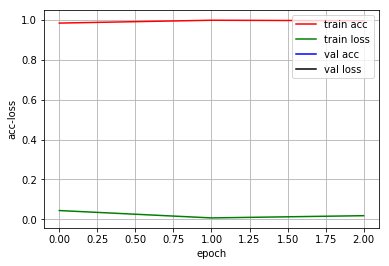

In [6]:
history.loss_plot('epoch')

### 打印信息

In [7]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 651, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 651, 256)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 166656)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 166656)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               21332096  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
__________

### 保存模型和参数

In [8]:
#保存模型
model.save('model.h5') 
#保存参数
model.save_weights('my_model_weights.h5')

In [9]:
model2 = load_model('model.h5')
loss,accuracy = model2.evaluate(X_test_r,y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

4169/4169 [==============================] - 1s 272us/step
Loss = 0.011541169427023676
Test Accuracy = 0.9971216118973375
